# Pre-Fit and Post-Fit plots
This notebook plots the pre/post-fit plots using the outputs from running runcards.py and runcombine.py. Firstly, make a `fitDiagnostics.root` file containin the pre/post-fit distributions by activating cmsenv and running 

`combine -M FitDiagnostics combined.root -m 200 --rMin -1 --rMax 2 --saveShapes --saveWithUncertainties`

Note that any other datacard is also fine and should give the same prefit and background only postfit distributions, but make sure to adjust the r-interval (--rMin, --rMax) accordingly.


In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import hist.intervals
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import mplhep as hep
import os

In [14]:
filename = "../allYears_720_v4/cards-GluGluToSUEP_HT1000_T3p00_mS1000.000_mPhi3.000_T3.000_modegeneric_TuneCP5_13TeV-pythia8/fitDiagnostics.root"  # replace with your actual ROOT file path
file = uproot.open(filename)

bins = np.array([90,110,130,170,500])
centers = np.array( [(bins[i] + bins[i + 1])/2 for i in range(len(bins) - 1)])

out_label = "/home/submit/{}/public_html/SUEP/debug/{}"
AN_label = '/home/submit/lavezzo/SUEP/AN-22-133/images/offline/{}.pdf'
saveToAN = True  # control whether to save to AN directory

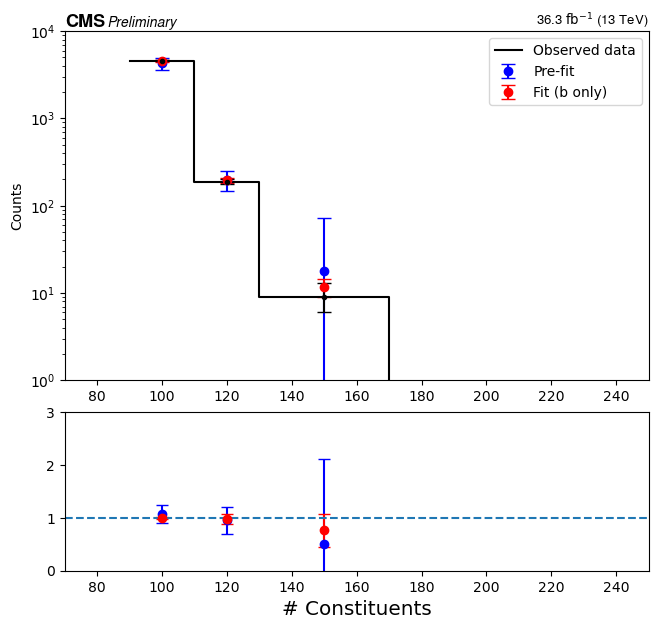

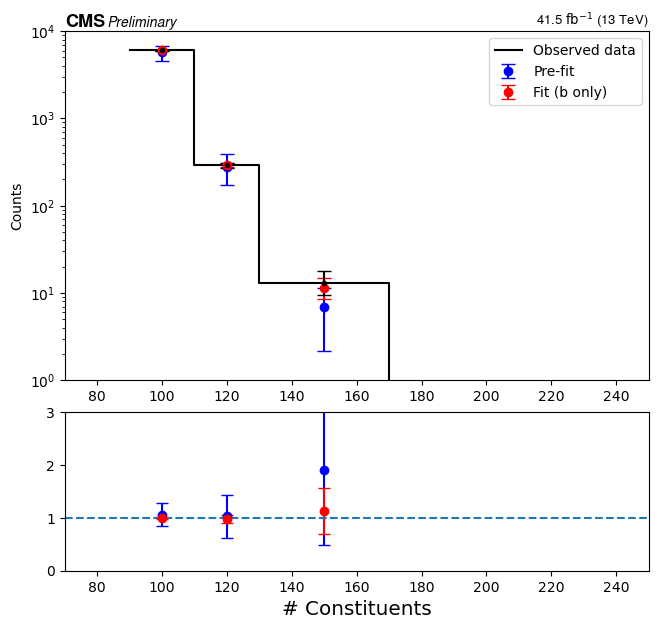

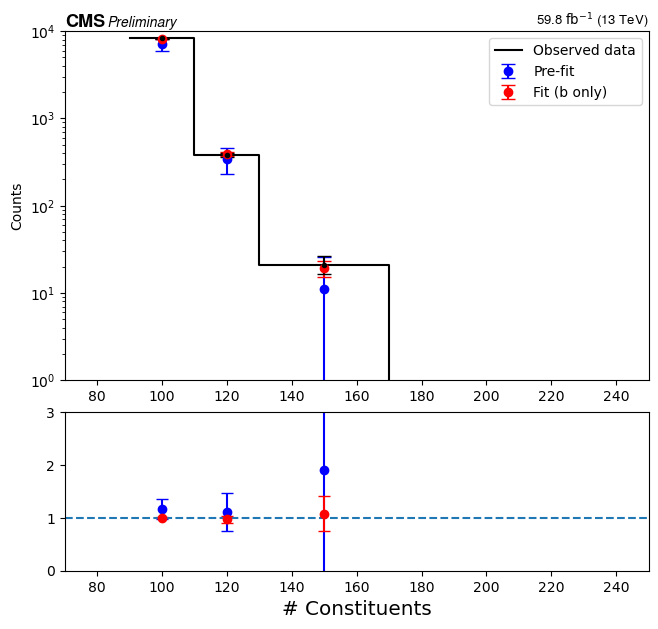

In [15]:
def compute_poisson_interval(values, confidence=0.6827):
    alpha = 1 - confidence
    low = chi2.ppf(alpha / 2., 2 * values) / 2
    high = chi2.ppf(1. - alpha / 2., 2 * (values + 1)) / 2
    return low, high

lumis = {
    "2016_apv": 19497.914,
    "2016": 16810.813,
    "2017": 41471.589,
    "2018": 59817.406,
    "all": 19497.914 + 16810.813 + 41471.589 + 59817.406,
}


def lumiLabel(year):
    if year in ["2017", "2018"]:
        return round(lumis[year] / 1000, 1)
    elif year == "2016":
        return round((lumis[year] + lumis[year + "_apv"]) / 1000, 1)
    elif year == 'all':
        return round(lumis[year] / 1000, 1)
    
expected, expected_err = {}, {}
data, data_err = {}, {}
for year in ['2016','2017','2018']:
    
    ### Collect data
    expected[year], expected_err[year] = {}, {}
    for fit in ['fit_b', 'prefit']:
                
        expected[year][fit] = np.array([]) 
        expected_err[year][fit] = np.array([])

        for sig_bins in ['Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig']: #['Bin0crF','Bin1crF','Bin2crF','Bin3crF','Bin4crF']

            name = 'shapes_{}/{}{};1'.format(fit,sig_bins,year)
            if name not in file.keys(): continue
            
            err = np.sqrt(file[name]['total_covar;1'].to_numpy()[0][0][0])
            expected[year][fit] = np.append(expected[year][fit],file[name]['expected;1'].values()[0])
            expected_err[year][fit] = np.append(expected_err[year][fit],err)
              
    data[year], data_err[year] = np.array([]), np.array([])
    for sig_bins in ['Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig']:
        name = 'shapes_{}/{}{};1'.format(fit,sig_bins,year)
        data[year] = np.append(data[year],file[name]['data;1'].values()[1])
    low, high = compute_poisson_interval(data[year]) 
    data_err[year] = (low, high)
    
    ### Plot everything
    fig = plt.figure(figsize=(8,10))
    fig.subplots_adjust(bottom=0.15, left=0.17)

    # Plot histograms
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)
    ax1.errorbar(centers, expected[year]['prefit'],label='Pre-fit',yerr=expected_err[year]['prefit'], fmt='o', capsize=5,c='b')
    if 'fit_s' in expected[year].keys(): ax1.errorbar(centers, expected[year]['fit_s'],label='Fit (s + b)',yerr=expected_err[year]['fit_s'], fmt='o', capsize=5,c='g')
    if 'fit_b' in expected[year].keys(): ax1.errorbar(centers, expected[year]['fit_b'],label='Fit (b only)',yerr=expected_err[year]['fit_b'], fmt='o', capsize=5,c='r')
    ax1.errorbar(centers, data[year],yerr=[data[year]-low,high-data[year]], fmt='.',c='black', capsize=5)
    ax1.step(bins, np.append(data[year],0),where='post',c='black',label='Observed data')

    ax1.set_ylabel("Counts")
    ax1.set_yscale('log')
    ax1.set_ylim(1e0, 1e4)
    ax1.legend()

    # Plot ratios
    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)

    ratio_prefit = np.divide(data[year], expected[year]['prefit'], out=np.ones_like(data[year]), where=data[year]!=0) #Overestimate
    prefit_err = np.sqrt( ((data[year]**2)*(expected[year]['prefit']**-4))*(expected_err[year]['prefit']**2) + (expected[year]['prefit']**-2)*(data[year]))
    if 'fit_s' in expected[year].keys(): 
        ratio_fit_s = np.divide(data[year], expected[year]['fit_s'], out=np.ones_like(data[year]), where=data[year]!=0) #Overestimate
        fit_s_err = np.sqrt( ((data[year]**2)*(expected[year]['fit_s']**-4))*(expected_err[year]['fit_s']**2) + (expected[year]['fit_s']**-2)*(data[year]))
    if 'fit_b' in expected[year].keys(): 
        ratio_fit_b = np.divide(data[year], expected[year]['fit_b'], out=np.ones_like(data[year]), where=data[year]!=0) #Overestimate
        fit_b_err = np.sqrt( ((data[year]**2)*(expected[year]['fit_b']**-4))*(expected_err[year]['fit_b']**2) + (expected[year]['fit_b']**-2)*(data[year]))
        
    ax2.errorbar(centers, ratio_prefit,fmt='o', color='b', label = 'Pre-fit',yerr= prefit_err,capsize=4)
    if 'fit_s' in expected[year].keys():  ax2.errorbar(centers, ratio_fit_s,fmt='o', color='g', label = 'Fit (s+b)',yerr= fit_s_err,capsize=4)
    if 'fit_b' in expected[year].keys():  ax2.errorbar(centers, ratio_fit_b,fmt='o', color='r', label = 'Fit (b)',yerr= fit_b_err,capsize=4)
    ax2.axhline(1,ls='--')
    ax2.set_xlim([70,250])
    ax2.set_ylim([0,3])
    ax2.set_xlabel(r"# Constituents", fontsize='x-large')
    
    hep.cms.label(llabel='Preliminary',data=True, lumi=lumiLabel(year), ax=ax1)

    plt.savefig(out_label.format(os.environ['USER'], 'postfit_'+year))
    if saveToAN: plt.savefig(AN_label.format("postfit_"+year), bbox_inches='tight')

    plt.show()

## Yields Table for AN

In [16]:
import math

def sf(value, error):
    # Calculate the number of significant figures based on the error
    significant_figures = round(-math.log10(error)) + 1

    # Round the value and error to the determined significant figures
    rounded_value = round(value, significant_figures)
    rounded_error = round(error, significant_figures)

    return rounded_value, rounded_error

In [17]:
labels = [
    r'$\# Const. \in ( 90, 110]$',
    r'$\# Const. \in ( 110, 130]$',
    r'$\# Const. \in ( 130, 170]$',
    r'$\# Const. \in ( 170, \inf]$',      
]

header = ' & '
for y in expected.keys(): header+= ' & ' + str(y)
print(header + r'\\')
for iBin in range(len(labels)):
    line1, line2 = '', ''
    line1 += 'Bin {}'.format(iBin+1) # we are Bin 0, since it's validation region
    line1 += ' & Exp.'
    line2 += labels[iBin] 
    line2 += ' & Obs.'
    
    for year in expected.keys():
        line1 += ' & '
        v, e = expected[year]['fit_b'][iBin], expected_err[year]['fit_b'][iBin]
        v, e = sf(v, e)
        line1 += '${} \pm {}$'.format(v, e)
        
    for year in data.keys():
        line2 += ' & '
        v, e_up, e_down = data[year][iBin], np.sqrt(data_err[year][0][iBin]), np.sqrt(data_err[year][0][iBin])
        if v == 0: 
            e_down, e_up = compute_poisson_interval(v)
            e_down = 0
        emax = max(e_up, e_down)
        v, _ = sf(v, emax)
        e_up, _ = sf(e_up, emax)
        e_down, _ = sf(e_down, emax)
        if e_up == e_down:
            line2 += '${} \pm {}$'.format(v, e_up)
        else:
            line2 += '$' + str(v) + '^{+' + str(e_up) + '}_{-' + str(e_down) + '}$'
    
    line1 += r'\\'
    line2 += r'\\'
    
    print('\hline')
    print(line1)
    print(line2)

 &  & 2016 & 2017 & 2018\\
\hline
Bin 1 & Exp. & $4550.0 \pm 60.0$ & $6050.0 \pm 70.0$ & $8230.0 \pm 90.0$\\
$\# Const. \in ( 90, 110]$ & Obs. & $4570.0 \pm 70.0$ & $6060.0 \pm 80.0$ & $8250.0 \pm 90.0$\\
\hline
Bin 2 & Exp. & $195.0 \pm 13.0$ & $294.0 \pm 15.0$ & $392.0 \pm 19.0$\\
$\# Const. \in ( 110, 130]$ & Obs. & $189.0 \pm 13.0$ & $289.0 \pm 16.0$ & $380.0 \pm 19.0$\\
\hline
Bin 3 & Exp. & $11.8 \pm 2.7$ & $11.5 \pm 3.1$ & $19.0 \pm 4.0$\\
$\# Const. \in ( 130, 170]$ & Obs. & $9.0 \pm 2.5$ & $13.0 \pm 3.1$ & $21.0 \pm 4.0$\\
\hline
Bin 4 & Exp. & $0.0 \pm 3e-05$ & $0.0 \pm 1.9e-05$ & $0.0 \pm 0.003$\\
$\# Const. \in ( 170, \inf]$ & Obs. & $0.0^{+1.8}_{-0}$ & $0.0^{+1.8}_{-0}$ & $0.0^{+1.8}_{-0}$\\
